In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    roc_curve, RocCurveDisplay,
    confusion_matrix, ConfusionMatrixDisplay
)


In [5]:
root = Path("../").resolve()
csv_path = root / "data" / "processed" / "scores_model.csv"

df = pd.read_csv(csv_path)

df = df[df["schedule_season"] >= 2002].dropna(subset=["home_spread", "over_under_line", "_home_win"])
df["_home_win"] = df["_home_win"].astype(int)

# Time-based split
train_df = df[df["schedule_season"] <= 2018].copy()
val_df   = df[(df["schedule_season"] >= 2019) & (df["schedule_season"] <= 2021)].copy()
test_df  = df[df["schedule_season"] >= 2022].copy()

FEATURES = ["home_spread", "over_under_line"]
TARGET = "_home_win"

X_train = train_df[FEATURES].values
y_train = train_df[TARGET].values

X_val = val_df[FEATURES].values
y_val = val_df[TARGET].values

X_test = test_df[FEATURES].values
y_test = test_df[TARGET].values


In [6]:
# Logistic Regression
log_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        solver="liblinear",
        penalty="l2",
        C=1.0,
        max_iter=1000,
    ))
])

# Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=10,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42,
)

# Gradient Boosting
gb = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=42,
)

# Fit models
log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

# Validation predictions
y_val_log_proba = log_reg.predict_proba(X_val)[:, 1]
y_val_rf_proba  = rf.predict_proba(X_val)[:, 1]
y_val_gb_proba  = gb.predict_proba(X_val)[:, 1]
y_val_gb_pred   = gb.predict(X_val)


/opt/miniconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


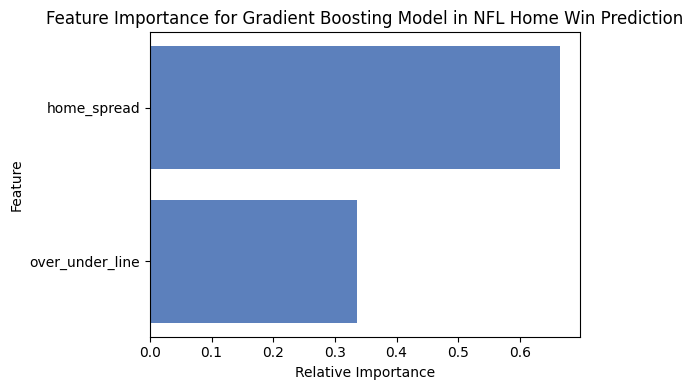

In [7]:
importances = gb.feature_importances_
feature_names = np.array(FEATURES)

fig, ax = plt.subplots(figsize=(6, 4))
order = np.argsort(importances)[::-1]
ax.barh(feature_names[order], importances[order], color="#5C80BC")
ax.invert_yaxis()

ax.set_title("Feature Importance for Gradient Boosting Model in NFL Home Win Prediction")
ax.set_xlabel("Relative Importance")
ax.set_ylabel("Feature")

plt.tight_layout()
plt.savefig("fig_feature_importance_gb.png", dpi=300)
plt.show()


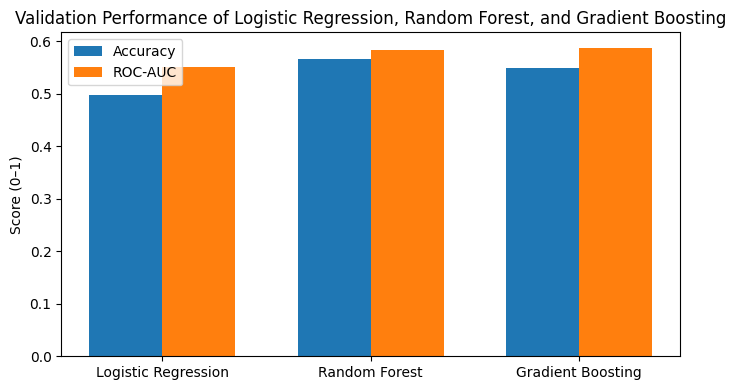

In [8]:
comp_path = root / "models" / "sprint3_validation_model_comparison.csv"
comp_df = pd.read_csv(comp_path)

fig, ax = plt.subplots(figsize=(7, 4))

x = np.arange(len(comp_df["model"]))
width = 0.35

ax.bar(x - width/2, comp_df["accuracy"], width, label="Accuracy")
ax.bar(x + width/2, comp_df["roc_auc"], width, label="ROC-AUC")

ax.set_xticks(x)
ax.set_xticklabels(comp_df["model"], rotation=0)
ax.set_ylabel("Score (0–1)")
ax.set_title("Validation Performance of Logistic Regression, Random Forest, and Gradient Boosting")
ax.legend()

plt.tight_layout()
plt.savefig("fig_model_comparison.png", dpi=300)
plt.show()


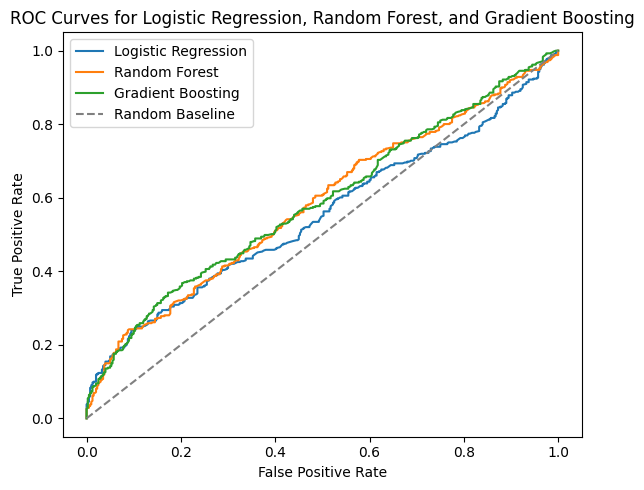

In [9]:
fig, ax = plt.subplots(figsize=(6, 5))

# ROC curves
for name, proba in [
    ("Logistic Regression", y_val_log_proba),
    ("Random Forest",       y_val_rf_proba),
    ("Gradient Boosting",   y_val_gb_proba),
]:
    fpr, tpr, _ = roc_curve(y_val, proba)
    ax.plot(fpr, tpr, label=name)

ax.plot([0, 1], [0, 1], "--", color="gray", label="Random Baseline")

ax.set_title("ROC Curves for Logistic Regression, Random Forest, and Gradient Boosting")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()

plt.tight_layout()
plt.savefig("fig_roc_curves.png", dpi=300)
plt.show()


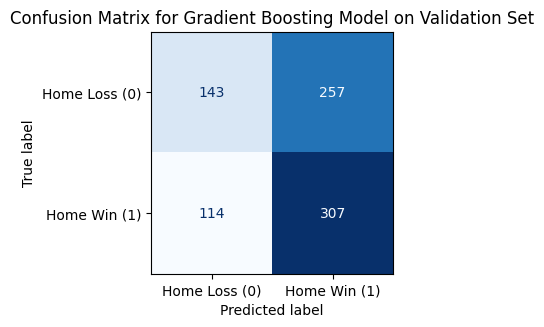

In [10]:
cm = confusion_matrix(y_val, y_val_gb_pred)

fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Home Loss (0)", "Home Win (1)"])
disp.plot(ax=ax, colorbar=False, cmap="Blues")

ax.set_title("Confusion Matrix for Gradient Boosting Model on Validation Set")

plt.tight_layout()
plt.savefig("fig_confusion_matrix_gb_val.png", dpi=300)
plt.show()


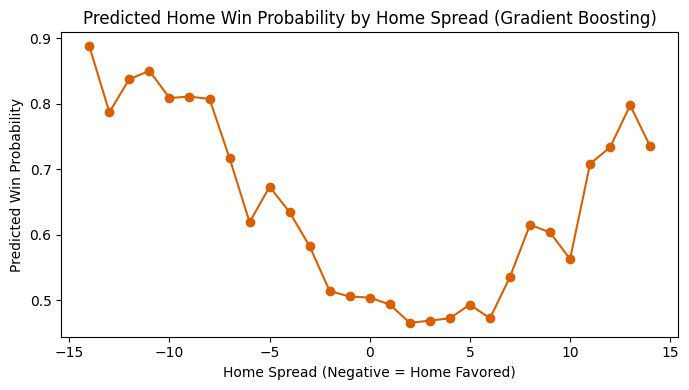

In [11]:
# Compute GB probabilities on test set
gb_final = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=42,
)
gb_final.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))

test_df_plot = test_df.copy()
test_df_plot["pred_prob"] = gb_final.predict_proba(X_test)[:, 1]
test_df_plot["spread_bin"] = test_df_plot["home_spread"].round().astype(int)

grouped = test_df_plot.groupby("spread_bin")["pred_prob"].mean().reset_index()

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(grouped["spread_bin"], grouped["pred_prob"], marker="o", color="#D95F02")

ax.set_title("Predicted Home Win Probability by Home Spread (Gradient Boosting)")
ax.set_xlabel("Home Spread (Negative = Home Favored)")
ax.set_ylabel("Predicted Win Probability")

plt.tight_layout()
plt.savefig("fig_home_spread_vs_prob.png", dpi=300)
plt.show()
